# Final Project: Used Car Price Predictor
### Author: Satish Agrawal, Sanjay Jaras

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import types
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso

## Configurations


In [2]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)

## Load Data
Data downloaded from https://www.kaggle.com/austinreese/craigslist-carstrucks-data


In [3]:
org_df = pd.read_csv("vehicles.csv", index_col=[0], converters={"cylinders":str})

### Show summary

In [4]:
org_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


### Show Original Data types

In [5]:
org_df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

### Let's drop column that we will not be using

In [6]:
#columns = ["region", "price", "year", "manufacturer", "model", "condition", "cylinders", "fuel", "odometer", "title_status", "transmission", 
#           "drive", "size", "type", "paint_color", "state", "lat", "long", "posting_date"]
#df_sel = org_df[columns]


### Consider dropping columns instead of subsetting for better clarity
df_sel = org_df.drop(columns=['url', 'id','image_url', 'description', 'region_url', 'VIN'])

# drop NA in important columns
#df_sel = org_df.dropna(subset=['year','condition','model','manufacturer'])

### Rename size column name to avoid keyword issue

In [7]:
df_sel.rename(columns={"size":"size_"}, inplace=True)

In [8]:
df_sel.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date
0,auburn,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,auburn,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,auburn,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,auburn,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,auburn,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


### Convert variables to appropriate data types

In [9]:
### Replace unknown and blank cylinder values with None

In [10]:
def replace_cylinders(x):
    
    if x == None or x.strip() == "" or x.strip() == "other":
        return None
    else: 
        return x.replace(" cylinders", "").strip()

### Need to replace "other" to something else from Cylinders
#df_sel.cylinders = df_sel.cylinders.apply(lambda x : replace_cylinders(x))

### Find Missing Values

In [11]:
df_sel.isnull().sum()

region               0
price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders            0
fuel              3237
odometer         55303
title_status      2577
transmission      2442
drive           134188
size_           321348
type            112738
paint_color     140843
state                0
lat               7448
long              7448
posting_date        28
dtype: int64

<AxesSubplot:>

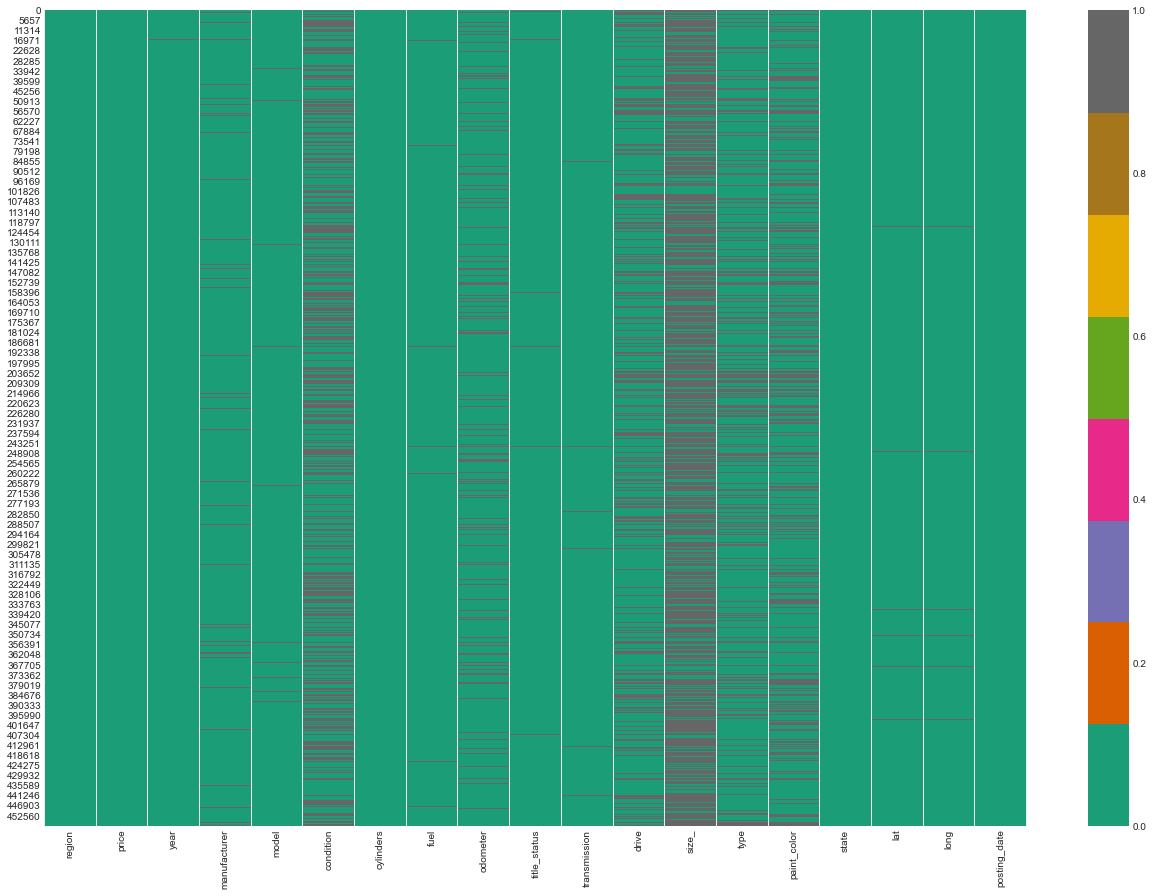

In [12]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.heatmap(df_sel.isnull(), cmap="Dark2")

In [13]:
num_attr = ["year", "odometer", "lat", "long"]
cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size_", "paint_color", "state", "type"]

### Fill missing values wiht Imputers

#### Convert categorical features to numeric using Label Encoder

In [14]:
# move target variable to last
price_col = df_sel.price
df_sel = df_sel.drop(columns=["price"])
df_sel["price"] = price_col

# Copy Data frame for Imputaion estimation
df_imputer = df_sel.copy()
label_encoder = LabelEncoder()
def labelEncode(catFeature):
    nonulls = np.array(catFeature.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = label_encoder.fit_transform(impute_reshape)
    catFeature.loc[catFeature.notnull()] = np.squeeze(impute_ordinal)
    return catFeature

for catFeature in cat_attr:
    labelEncode(df_imputer[catFeature])
    

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
df_imputer.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date,price
0,16,2010.0,7,12317,2,7,2,32742.0,0,2,2,NaN,7,NaN,1,32.590000,-85.480000,2020-12-02T08:11:30-0600,35990
1,16,2014.0,18,27213,0,4,2,93600.0,0,0,1,NaN,9,NaN,1,32.547500,-85.468200,2020-12-02T02:11:50-0600,7500
2,16,2006.0,4,30748,2,6,2,87046.0,0,0,NaN,NaN,0,1,1,32.616807,-85.464149,2020-12-01T19:50:41-0600,4900
3,16,1974.0,7,10101,2,4,2,190000.0,0,0,2,1,8,1,1,32.861600,-85.216100,2020-12-01T15:54:45-0600,2000
4,16,2005.0,13,16813,0,7,0,116000.0,1,0,0,1,8,1,1,32.547500,-85.468200,2020-12-01T12:53:56-0600,19500


In [16]:
drop_cols = []
drop_cols.append("posting_date")
#drop_cat.extend(num_attr)
#print(drop_cat)
df_imputer = df_imputer.drop(columns=drop_cols)

df_imputer.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size_',
       'type', 'paint_color', 'state', 'lat', 'long', 'price'],
      dtype='object')

### Find good estimator to fill missing values for categorical features

#### Simple Imputer

In [17]:
score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=df_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(df_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.NaN, strategy=strategy),
        BayesianRidge()
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=None
    )


#### Iterative Imputers

In [18]:
# Estimate the score on the entire dataset by filling missing values by different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=random_state),
    ExtraTreesRegressor(n_estimators=10, random_state=random_state, n_jobs=10),
    KNeighborsRegressor(n_neighbors=10, n_jobs=10),
    #SGDRegressor(random_state=random_state),
    Lasso(random_state=random_state)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=df_imputer.copy()
        for col in df_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error')

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor
Estimating Lasso


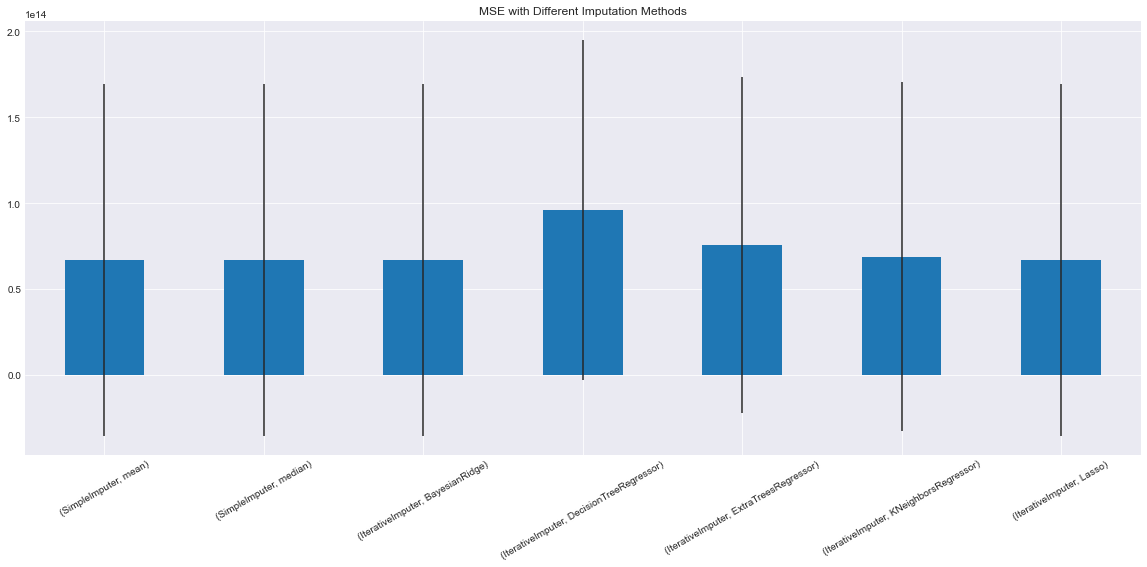



Method with Minimum Error ('IterativeImputer', 'ExtraTreesRegressor')


In [19]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax =plt.subplots(1,figsize=(20, 8))
means = -scores.mean()
errors = scores.std()
means.plot(kind="bar", yerr=errors)
plt.xticks(rotation=30)
plt.title("MSE with Different Imputation Methods")
plt.show()

print("\n\nMethod with Minimum Error", errors.idxmin())
name = errors.idxmin()

### Select Estimator for filling missing values

In [20]:
selected_est =  estimators[2]
print(selected_est)    

ExtraTreesRegressor(n_estimators=10, n_jobs=10, random_state=17)


### Fill missing values for Numerical Atrributes

In [21]:
df_sel.isnull().sum()[num_attr]

year         1050
odometer    55303
lat          7448
long         7448
dtype: int64

In [22]:
df_num=df_sel[num_attr]
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_num)
df_sel[num_attr]=imputed_data

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [23]:
df_sel.isnull().sum()[num_attr]

year        0
odometer    0
lat         0
long        0
dtype: int64

### Fill missing values for Categorical Atrributes

In [24]:
df_sel.isnull().sum()[cat_attr]

region               0
manufacturer     18220
model             4846
condition       192940
cylinders            0
fuel              3237
title_status      2577
transmission      2442
drive           134188
size_           321348
paint_color     140843
state                0
type            112738
dtype: int64

In [25]:
# encode categorical columns to numbers
for catFeature in cat_attr:
    labelEncode(df_sel[catFeature])
    
# Fill missing values
df_cat=df_sel[cat_attr]
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_cat)
df_sel[cat_attr]=imputed_data

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [26]:
df_sel.isnull().sum()[cat_attr]

region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size_           0
paint_color     0
state           0
type            0
dtype: int64

### Distribution and outlier for years

In [27]:
df_sel.year.describe()

count    458213.000000
mean       2010.748852
std           8.865706
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2021.000000
Name: year, dtype: float64

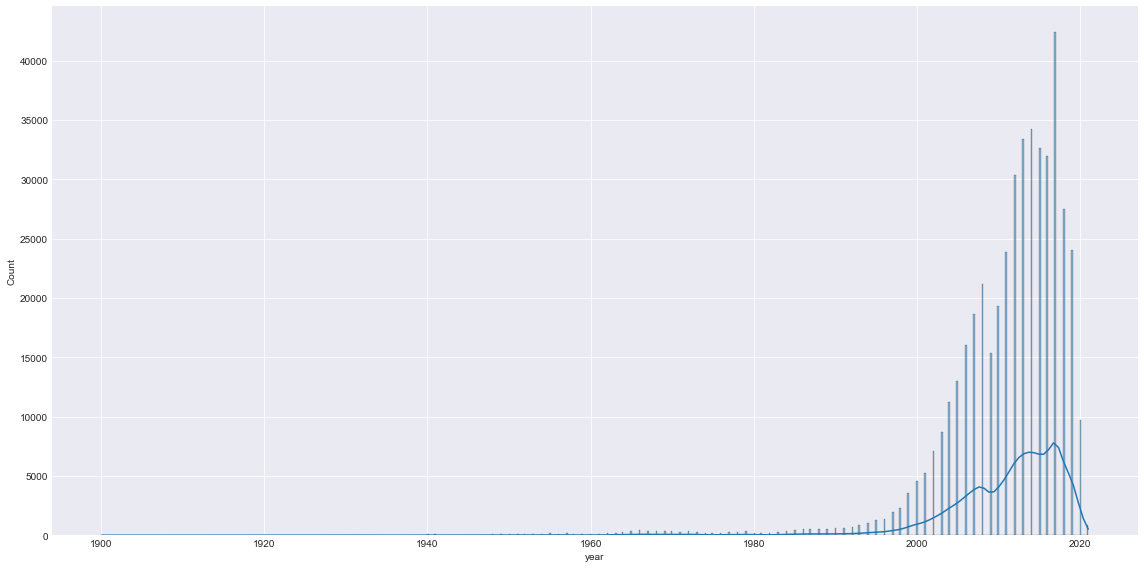

In [28]:
sns.displot(x=df_sel.year, kde=True, height=8, aspect=2 )
plt.show()

### Distribution and outlier for odometer

In [29]:
df_sel.odometer.describe()

count    4.582130e+05
mean     1.042159e+05
std      3.028472e+06
min      0.000000e+00
25%      4.330200e+04
50%      9.078000e+04
75%      1.367487e+05
max      2.043756e+09
Name: odometer, dtype: float64

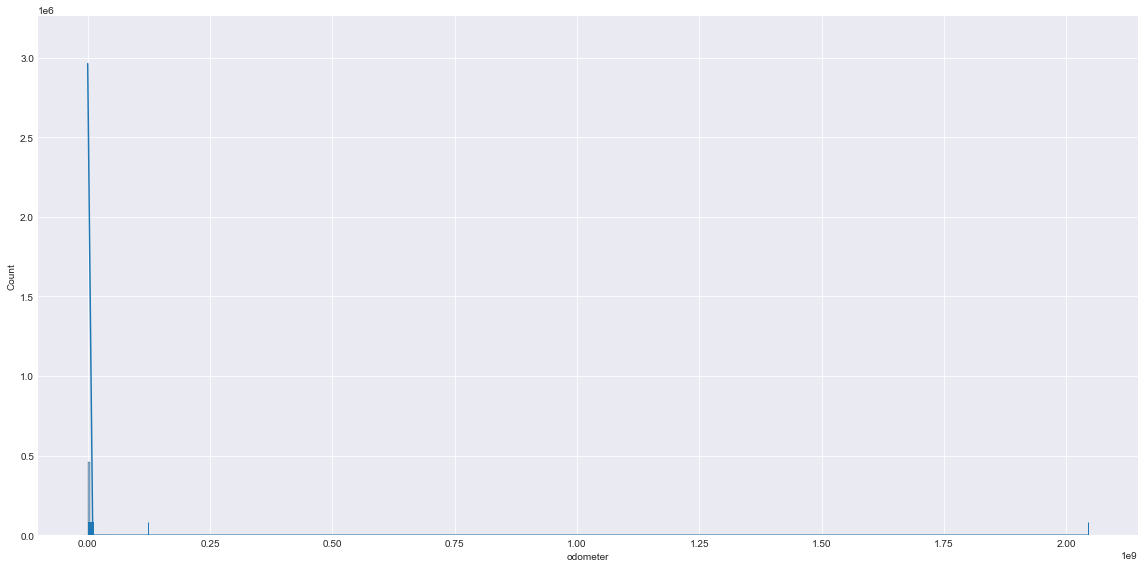

In [30]:
sns.displot(x=df_sel.odometer, kde=True, rug=True, height=8, bins=500, aspect=2 )
plt.show()



### Distribution and outlier for price

In [31]:
df_sel.price.describe()

count    4.582130e+05
mean     4.042093e+04
std      8.194599e+06
min      0.000000e+00
25%      4.900000e+03
50%      1.099500e+04
75%      2.149500e+04
max      3.615215e+09
Name: price, dtype: float64

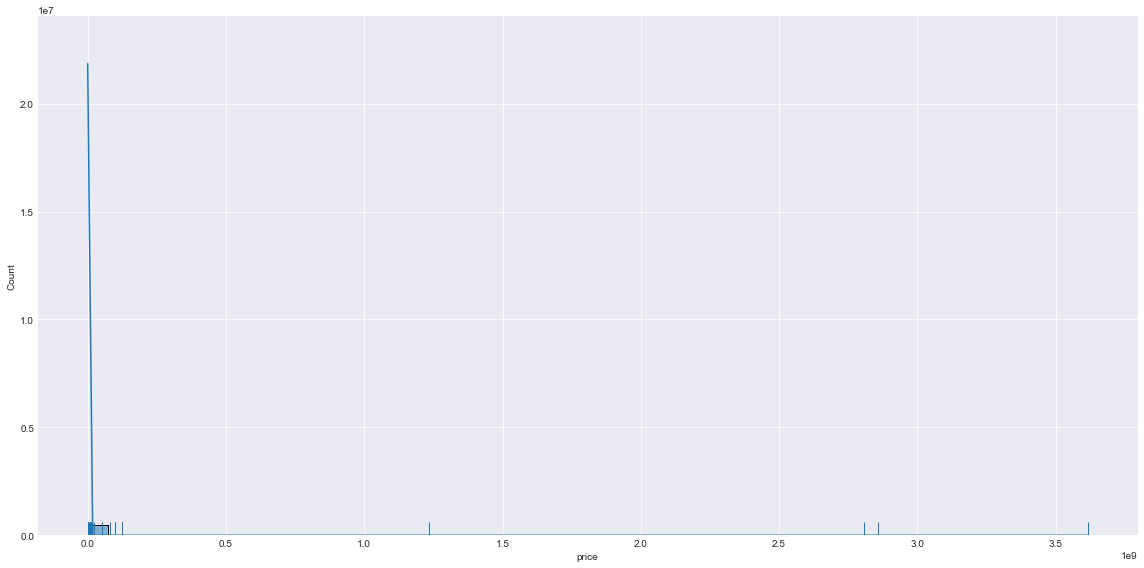

In [32]:
sns.displot(x=df_sel.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

In [33]:
df_sel.region = pd.Categorical(df_sel.region)
df_sel.year = pd.Categorical(df_sel.year)
df_sel.manufacturer = pd.Categorical(df_sel.manufacturer)
df_sel.model = pd.Categorical(df_sel.model)
df_sel.condition = pd.Categorical(df_sel.condition)
df_sel.fuel = pd.Categorical(df_sel.fuel)
df_sel.title_status = pd.Categorical(df_sel.title_status)
df_sel.transmission = pd.Categorical(df_sel.transmission)
df_sel.drive = pd.Categorical(df_sel.drive)
df_sel.size_ = pd.Categorical(df_sel.size_)
df_sel.type = pd.Categorical(df_sel.type)
df_sel.paint_color = pd.Categorical(df_sel.paint_color)
df_sel.state = pd.Categorical(df_sel.state, )

In [34]:
df_sel = df_sel[df_sel.year.notnull()]
df_sel["age"] = df_sel.year.apply(lambda x: int(2020-x))

In [35]:
df_sel.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date,price,age
0,16.0,2010.0,7.0,12317.0,2.0,7.0,2.0,32742.0,0.0,2.0,2.000000,1.9,7.0,7.5,1.0,32.590000,-85.480000,2020-12-02T08:11:30-0600,35990,10
1,16.0,2014.0,18.0,27213.0,0.0,4.0,2.0,93600.0,0.0,0.0,1.000000,1.6,9.0,2.7,1.0,32.547500,-85.468200,2020-12-02T02:11:50-0600,7500,6
2,16.0,2006.0,4.0,30748.0,2.0,6.0,2.0,87046.0,0.0,0.0,0.833333,1.5,0.0,1.0,1.0,32.616807,-85.464149,2020-12-01T19:50:41-0600,4900,14
3,16.0,1974.0,7.0,10101.0,2.0,4.0,2.0,190000.0,0.0,0.0,2.000000,1.0,8.0,1.0,1.0,32.861600,-85.216100,2020-12-01T15:54:45-0600,2000,46
4,16.0,2005.0,13.0,16813.0,0.0,7.0,0.0,116000.0,1.0,0.0,0.000000,1.0,8.0,1.0,1.0,32.547500,-85.468200,2020-12-01T12:53:56-0600,19500,15


### Need to replace other to something else

<AxesSubplot:xlabel='model', ylabel='count'>

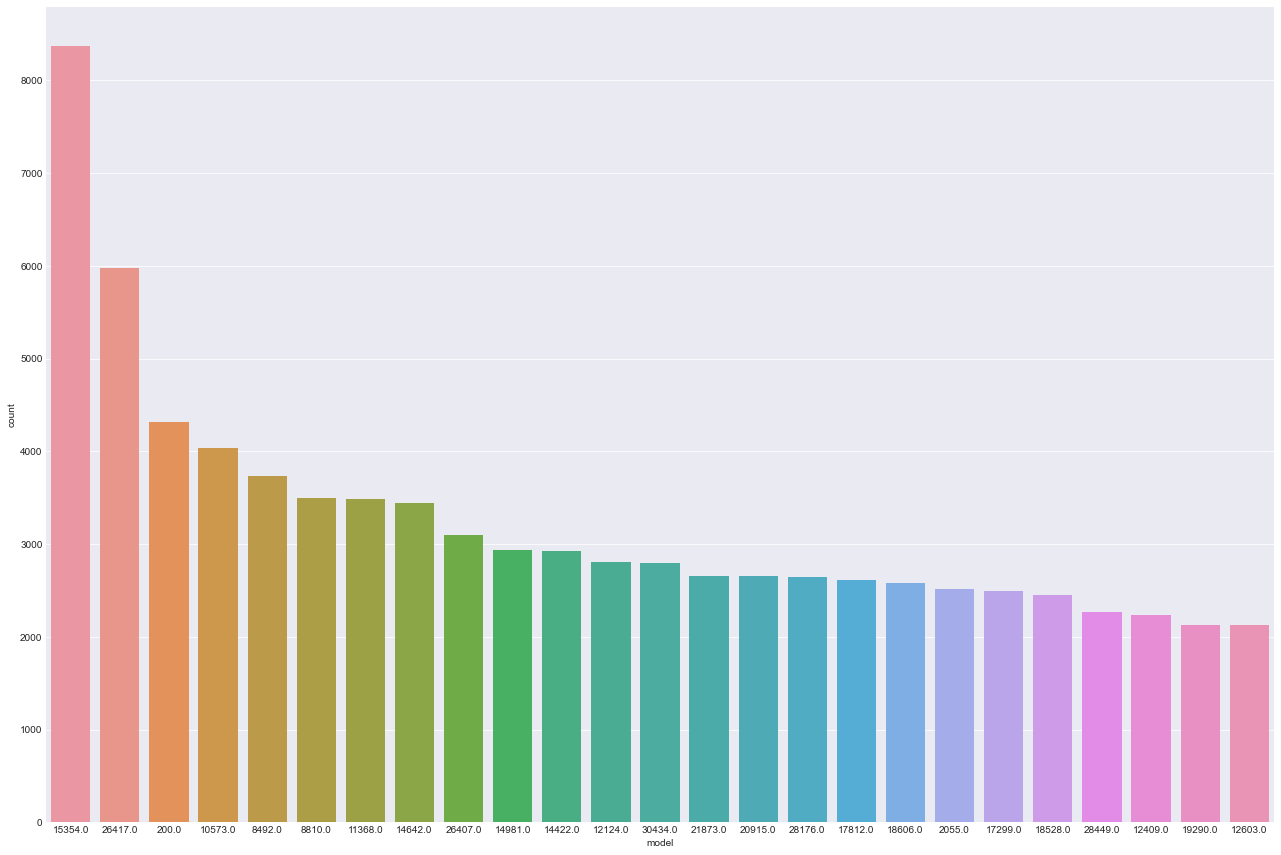

In [36]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.countplot(x ='model', data = df_sel, order=df_sel.model.value_counts().iloc[:25].index)

<AxesSubplot:xlabel='manufacturer', ylabel='count'>

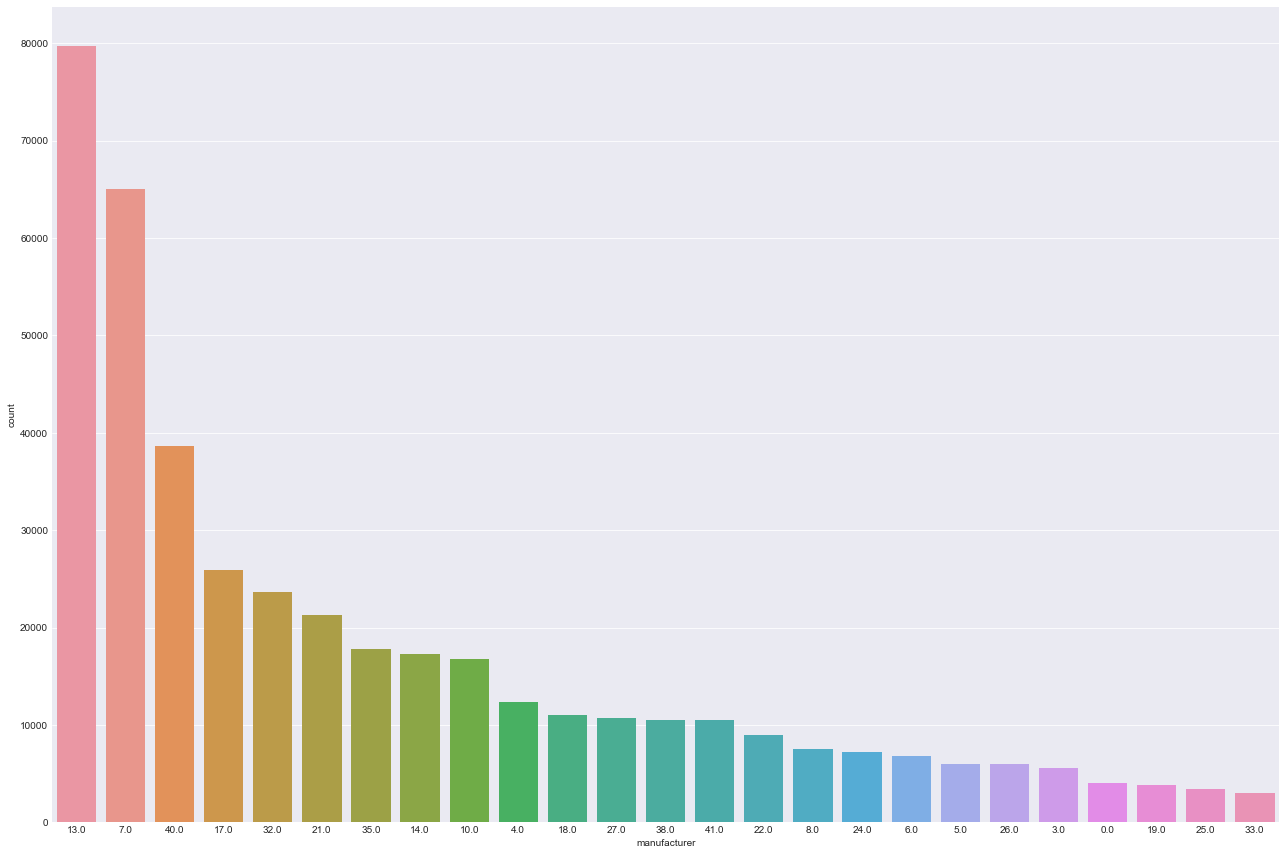

In [37]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.countplot(x ='manufacturer',data = df_sel,order=df_sel.manufacturer.value_counts().iloc[:25].index)

<AxesSubplot:xlabel='type', ylabel='count'>

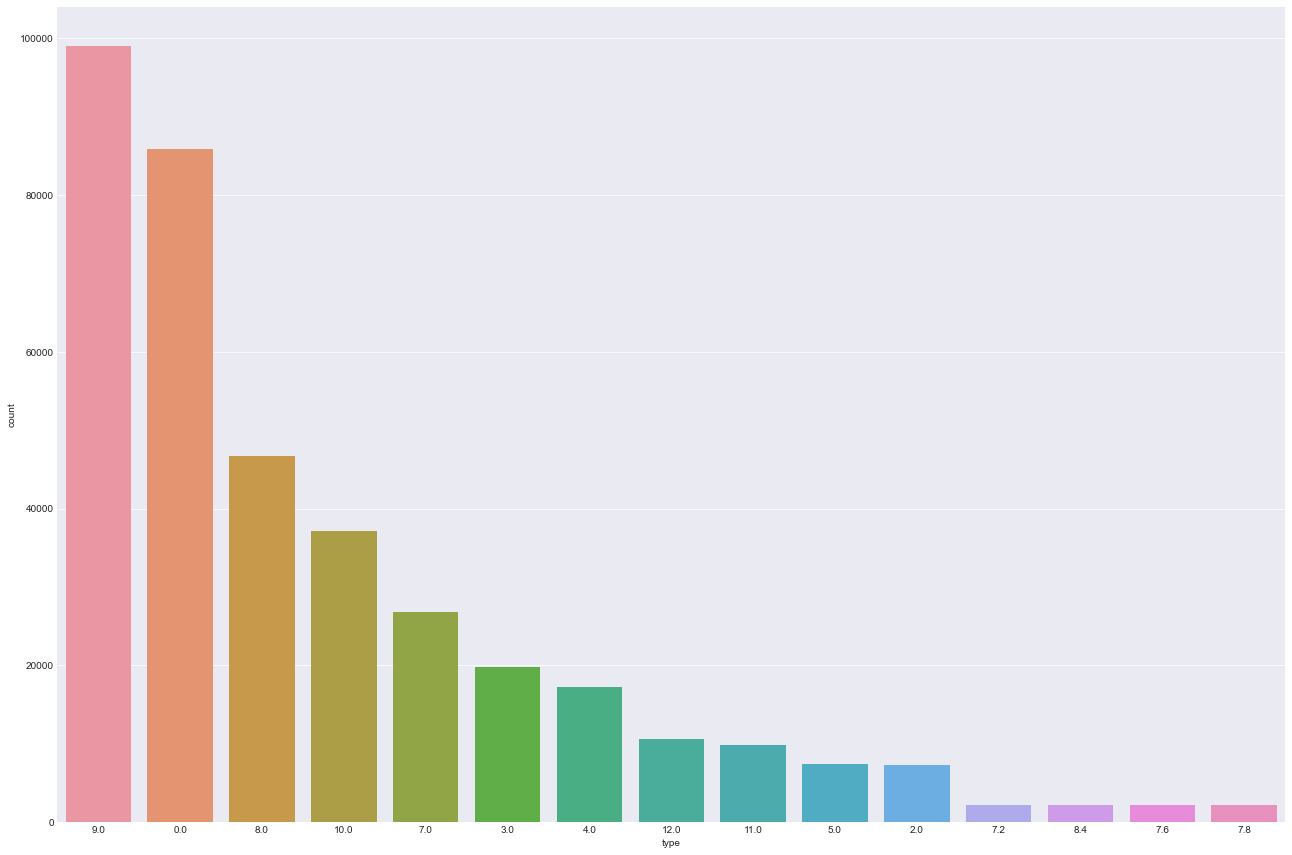

In [38]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.countplot(x ='type',data = df_sel,order=df_sel.type.value_counts().iloc[:15].index)

In [39]:
#sns.pairplot(data = df_sel)

In [40]:
df_sel.condition.unique()
df_sel = df_sel.dropna()

In [41]:
df_sel.condition.unique()

[2.0, 0.0, 1.3, 3.0, 1.9, ..., 2.033333, 2.011111, 0.341667, 1.833333, 2.550000]
Length: 248
Categories (248, float64): [2.0, 0.0, 1.3, 3.0, ..., 2.011111, 0.341667, 1.833333, 2.550000]

In [42]:
df_dummies = pd.get_dummies(df_sel.condition)

In [43]:
df_condition = pd.concat([df_sel.price, df_dummies], axis=1)
df_condition

,price,0.0,0.04166666666666667,0.05,0.06666666666666667,0.075,0.1,0.13333333333333333,0.15,0.16666666666666669,...,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.2,4.7,5.0
0,35990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7500,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4900,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19500,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,14995,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
458209,17895,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
458210,17900,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
458211,1300,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df_condition.corr()

,price,0.0,0.04166666666666667,0.05,0.06666666666666667,0.075,0.1,0.13333333333333333,0.15,0.16666666666666669,...,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.2,4.7,5.0
price,1.000000,-0.001808,-0.000005,-0.000007,-0.000023,-0.000014,-0.000138,-0.000016,-0.000020,-0.000014,...,-0.000021,-0.000023,-0.000021,-0.000009,-0.000018,-0.000004,-0.000122,-0.000007,-0.000007,-0.000172
0.0,-0.001808,1.000000,-0.000911,-0.000911,-0.003529,-0.001823,-0.028455,-0.003157,-0.003286,-0.002411,...,-0.003410,-0.003972,-0.003645,-0.002411,-0.002577,-0.000911,-0.035066,-0.000911,-0.000911,-0.023569
0.04166666666666667,-0.000005,-0.000911,1.000000,-0.000002,-0.000008,-0.000004,-0.000068,-0.000008,-0.000008,-0.000006,...,-0.000008,-0.000010,-0.000009,-0.000006,-0.000006,-0.000002,-0.000084,-0.000002,-0.000002,-0.000056
0.05,-0.000007,-0.000911,-0.000002,1.000000,-0.000008,-0.000004,-0.000068,-0.000008,-0.000008,-0.000006,...,-0.000008,-0.000010,-0.000009,-0.000006,-0.000006,-0.000002,-0.000084,-0.000002,-0.000002,-0.000056
0.06666666666666667,-0.000023,-0.003529,-0.000008,-0.000008,1.000000,-0.000017,-0.000264,-0.000029,-0.000030,-0.000022,...,-0.000032,-0.000037,-0.000034,-0.000022,-0.000024,-0.000008,-0.000325,-0.000008,-0.000008,-0.000219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.9,-0.000004,-0.000911,-0.000002,-0.000002,-0.000008,-0.000004,-0.000068,-0.000008,-0.000008,-0.000006,...,-0.000008,-0.000010,-0.000009,-0.000006,-0.000006,1.000000,-0.000084,-0.000002,-0.000002,-0.000056
4.0,-0.000122,-0.035066,-0.000084,-0.000084,-0.000325,-0.000168,-0.002623,-0.000291,-0.000303,-0.000222,...,-0.000314,-0.000366,-0.000336,-0.000222,-0.000238,-0.000084,1.000000,-0.000084,-0.000084,-0.002172
4.2,-0.000007,-0.000911,-0.000002,-0.000002,-0.000008,-0.000004,-0.000068,-0.000008,-0.000008,-0.000006,...,-0.000008,-0.000010,-0.000009,-0.000006,-0.000006,-0.000002,-0.000084,1.000000,-0.000002,-0.000056
4.7,-0.000007,-0.000911,-0.000002,-0.000002,-0.000008,-0.000004,-0.000068,-0.000008,-0.000008,-0.000006,...,-0.000008,-0.000010,-0.000009,-0.000006,-0.000006,-0.000002,-0.000084,-0.000002,1.000000,-0.000056


In [45]:
from scipy.stats import pointbiserialr
from scipy.stats import kruskal
from scipy.stats import f_oneway
print(pointbiserialr(df_condition.price, df_condition.excellent))
print(kruskal(df_condition.price, df_condition.excellent))
print(f_oneway(df_condition.price, df_condition.excellent))

AttributeError: 'DataFrame' object has no attribute 'excellent'